# Mini Project 3 — Mental Health & Burnout in the Workplace Analysis
<!-- Complusory:

Module 6: Unsupervised Classification and Clustering

Module 8: NLP (Natural Language Processing) and LLM (Large Language Models)

Optional:
Include Supervised ML models -->

#### Import all the python libraries required for this project

In [1]:
# === Core scientific stack ===
import numpy as np
import pandas as pd
from scipy import stats

# === Plotting ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Utilities / IO ===
import requests
from IPython.display import display, clear_output

from sklearn.calibration import CalibratedClassifierCV

# === Scikit-learn ===
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SequentialFeatureSelector

# === Models packages ===
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.base import clone

# === Models packages (ensemble) ===
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# === Evaulation ML ===
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, roc_auc_score, 
    balanced_accuracy_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer

import pickle, json, time, platform, sklearn

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

## 1. Load CSV Data and EDA Analysis
Begin by loading the dataset and conducting an Exploratory Data Analysis (EDA) to understand the structure of the data, examine feature distributions, identify missing values, and explore relationships between work-related factors and mental-health outcomes.
The goal is to identify which variables are most relevant for predicting stress, burnout, and overall workplace mental health.

Reference from: https://www.kaggle.com/datasets/khushikyad001/mental-health-and-burnout-in-the-workplace


### About This Dataset
This synthetic dataset simulates survey responses from 3,000 professionals across various roles and countries. It captures burnout, stress, job satisfaction, and workplace wellness factors over time. The goal is to explore mental health trends, predict burnout risks, and analyze how workplace variables affect productivity and well-being.

This dataset is ideal for analysing how different professions (e.g., FIFO, tech, corporate, healthcare workers) experience stress and burnout, and for building unsupervised, supervised, and NLP/LLM components.


In [3]:
file = "data/mental_health_workplace_survey.csv"
df = pd.read_csv(file)

In [4]:
df.head()

EmployeeID  Age      Gender    Country            JobRole Department  \
0        1001   50        Male         UK    Sales Associate         HR   
1        1002   36        Male    Germany  Software Engineer         IT   
2        1003   29  Non-binary      India           IT Admin         IT   
3        1004   42        Male  Australia      HR Specialist         IT   
4        1005   40        Male     Brazil   Customer Support    Support   

   YearsAtCompany  WorkHoursPerWeek RemoteWork  BurnoutLevel  ...  \
0              14                47         No          3.37  ...   
1               1                59     Hybrid          7.39  ...   
2              13                59     Hybrid          7.10  ...   
3              15                31        Yes          4.18  ...   
4               6                34        Yes          8.28  ...   

   CommuteTime  HasMentalHealthSupport  ManagerSupportScore  HasTherapyAccess  \
0          117                      No                 3.15               Yes   
1            8                     Yes                 4.40               Yes   
2           75                      No                 3.63                No   
3           43                     Yes                 4.50               Yes   
4           58                     Yes                 5.51               Yes   

   MentalHealthDaysOff  SalaryRange WorkLifeBalanceScore  TeamSize  \
0                    8      40K-60K                 8.82         6   
1                    4     80K-100K                 2.80        45   
2                    6     80K-100K                 7.28         7   
3                    9      60K-80K                 1.31        11   
4                    6         <40K                 1.17        18   

  CareerGrowthScore  BurnoutRisk  
0              9.20            0  
1              8.46            1  
2              7.96            1  
3              8.90            0  
4              8.88            1  

[5 rows x 25 columns]

In [5]:
df.columns

Index(['EmployeeID', 'Age', 'Gender', 'Country', 'JobRole', 'Department',
       'YearsAtCompany', 'WorkHoursPerWeek', 'RemoteWork', 'BurnoutLevel',
       'JobSatisfaction', 'StressLevel', 'ProductivityScore', 'SleepHours',
       'PhysicalActivityHrs', 'CommuteTime', 'HasMentalHealthSupport',
       'ManagerSupportScore', 'HasTherapyAccess', 'MentalHealthDaysOff',
       'SalaryRange', 'WorkLifeBalanceScore', 'TeamSize', 'CareerGrowthScore',
       'BurnoutRisk'],
      dtype='object')

### 1.1 Column Descriptions:

25 Features:<br>
**Demographic & Background Features**
- Age
- Gender
- Country
- JobRole
- YearsAtCompany

**Work Conditions & Environment**
- WorkHoursPerWeek
- RemoteWork
- CommuteTime
- SalaryRange
- Burnout, Stress & Mental Health
- BurnoutLevel
- StressLevel
- HasMentalHealthSupport
- HasTherapyAccess
- MentalHealthDaysOff

**Performance & Satisfaction**
- JobSatisfaction
- ProductivityScore
- WorkLifeBalanceScore
- Lifestyle & Health Indicators
- PhysicalActivityHrs

Target Variable
- BurnoutRisk (either a 0 or a 1)


In [5]:
df.shape

(3000, 25)

In [6]:
print(df.describe())

        EmployeeID          Age  YearsAtCompany  WorkHoursPerWeek  \
count  3000.000000  3000.000000     3000.000000       3000.000000   
mean   2500.500000    40.805667       10.099333         44.504000   
std     866.169729    11.011705        6.035032          8.491526   
min    1001.000000    22.000000        0.000000         30.000000   
25%    1750.750000    31.000000        5.000000         37.000000   
50%    2500.500000    41.000000       10.000000         45.000000   
75%    3250.250000    50.000000       15.000000         52.000000   
max    4000.000000    59.000000       20.000000         59.000000   

       BurnoutLevel  JobSatisfaction  StressLevel  ProductivityScore  \
count   3000.000000       3000.00000   3000.00000         3000.00000   
mean       5.509137          5.43750      5.51535            5.51956   
std        2.574072          2.59443      2.60361            2.60761   
min        1.000000          1.00000      1.00000            1.00000   
25%        3.30000

In [7]:
# Count missing values in each column
# For this case, lucky there is no NAs
print(df.isna().sum())

EmployeeID                0
Age                       0
Gender                    0
Country                   0
JobRole                   0
Department                0
YearsAtCompany            0
WorkHoursPerWeek          0
RemoteWork                0
BurnoutLevel              0
JobSatisfaction           0
StressLevel               0
ProductivityScore         0
SleepHours                0
PhysicalActivityHrs       0
CommuteTime               0
HasMentalHealthSupport    0
ManagerSupportScore       0
HasTherapyAccess          0
MentalHealthDaysOff       0
SalaryRange               0
WorkLifeBalanceScore      0
TeamSize                  0
CareerGrowthScore         0
BurnoutRisk               0
dtype: int64


## 2. Add a New Column for LLM-Generated Descriptions

To enable NLP and LLM-based analysis, a new column will be added to the dataset to store generated text descriptions for each individual. These descriptions will summarize the person’s job role, stress levels, burnout score, lifestyle factors, and financial pressures.
This turns the dataset from purely numerical/categorical into a hybrid structured + unstructured dataset, allowing for deeper NLP insights.


In [8]:
unique_roles = df["JobRole"].unique()
unique_roles

array(['Sales Associate', 'Software Engineer', 'IT Admin',
       'HR Specialist', 'Customer Support', 'Project Manager',
       'Marketing Manager', 'Data Scientist'], dtype=object)

In [9]:
df["JobRole"].value_counts()

JobRole
Data Scientist       411
Software Engineer    401
Customer Support     380
Marketing Manager    372
Project Manager      362
HR Specialist        361
IT Admin             358
Sales Associate      355
Name: count, dtype: int64

Drop off columns not needed for the prompt to be included

In [ ]:
df = df.drop(columns=["EmployeeID", "Department", "TeamSize"])
df.columns

Index(['Age', 'Gender', 'Country', 'JobRole', 'YearsAtCompany',
       'WorkHoursPerWeek', 'RemoteWork', 'BurnoutLevel', 'JobSatisfaction',
       'StressLevel', 'ProductivityScore', 'SleepHours', 'PhysicalActivityHrs',
       'CommuteTime', 'HasMentalHealthSupport', 'ManagerSupportScore',
       'HasTherapyAccess', 'MentalHealthDaysOff', 'SalaryRange',
       'WorkLifeBalanceScore', 'CareerGrowthScore', 'BurnoutRisk'],
      dtype='object')

### Let get 15 for each job_role and randomly sample the data

In [11]:
# Number of samples per job role
N = 15

# Sample 15 from each JobRole (if available)
df_sampled = (
    df.groupby("JobRole", group_keys=False)
      .apply(lambda x: x.sample(min(len(x), N), random_state=42))
)

# Reset index after sampling
df_sampled = df_sampled.reset_index(drop=True)

# Show result
print(df_sampled["JobRole"].value_counts())

# Save to CSV if you want
df_sampled.to_csv("data/jobrole_sampled_15each.csv", index=False)

JobRole
Customer Support     15
Data Scientist       15
HR Specialist        15
IT Admin             15
Marketing Manager    15
Project Manager      15
Sales Associate      15
Software Engineer    15
Name: count, dtype: int64


C:\Users\Aaron\AppData\Local\Temp\ipykernel_3684\4170282626.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), N), random_state=42))


Since there is no time to self generate-text for all the rows.

The next plan is to use a sample 15 sample job_role fo each only and put only a LLM text based on it.

### Use this to only test the output

In [ ]:
# def build_prompt(row):
#     row_dict = row.to_dict()
#     attributes = "\n".join([f"{col}: {value}" for col, value in row_dict.items()])

#     prompt = f"""
#     DO NOT begin with 'Based on the provided details' or similar phrases.

#     Generate EXACTLY 2 sentences describing workplace wellbeing using these attributes:

#     {attributes}

#     Use clear, analytical language suitable for NLP extraction.
#     """
#     return prompt


# for i in range(3):
#     row = df.loc[i][1:]
#     prompt = build_prompt(row)
#     print("\n--- Prompt for Row", i, "---")
#     print(prompt)

In [12]:
EXTRA_DETAILS = {
    "BurnoutLevel": "(0 = none, 10 = worst)",
    "StressLevel": "(0 = best, 10 = worst)",
    "JobSatisfaction": "(0 = worst, 10 = best)",
    "ProductivityScore": "(0 = worst, 10 = best)",
    "SleepHours": "(daily hours)",
    "WorkLifeBalanceScore": "(0 = poor, 10 = excellent)",
    "ManagerSupportScore": "(0 = poor, 10 = excellent)",
    "BurnoutRisk": ("0 = No, 1 = Yes")
}

In [ ]:
%%time

import os
from groq import Groq
from dotenv import load_dotenv

# Load dataset
df = pd.read_csv("data/jobrole_Sampled_15each.csv")

# Groq client
api_key = os.getenv("GROQ_API_KEY")
client = Groq(api_key=os.getenv(api_key))

# Choose a Groq model (fast & high-quality)
MODEL = "llama-3.1-8b-instant"  

# --- 1. Function: generate using Groq ---
def generate_with_groq(prompt):
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        stream=False    # we want the FULL result, not token streaming
    )

    return response.choices[0].message.content.strip()

# --- 2. Build the prompt ---
def build_prompt(row):
    row_dict = row.to_dict()

    attributes = []
    for col, value in row_dict.items():
        if col in EXTRA_DETAILS:
            attributes.append(f"{col}: {value} {EXTRA_DETAILS[col]}")
        else:
            attributes.append(f"{col}: {value}")

    attributes_text = "\n".join(attributes)

    prompt = f"""
    DO NOT begin with any phrases like 'Based on the provided details'.
    DO NOT summarize the attributes themselves.

    Generate EXACTLY **3 sentences** describing workplace wellbeing using these attributes. Write as in how would an employee felt overall.
    Focus ONLY on wellbeing indicators.
    Incorporate the most important factors (e.g., high stress levels).

    Attributes:
    {attributes_text}
    """

    desc = generate_with_groq(prompt)
    df.loc[i, "SurveyDescription"] = desc 


# --- 3. Loop through rows ---
N = len(df)   # change to len(df) for full dataset

for i in range(N):
    print(f"\n--- Generating row {i+1}/{N} ---")
    row = df.loc[i]
    text = build_prompt(row)

# 6. Save file
df.to_csv("data/mental_health_15_descriptions.csv", index=False)
print("DONE — SurveyDescription column generated!")


--- Generating row 1/120 ---

--- Generating row 2/120 ---

--- Generating row 3/120 ---

--- Generating row 4/120 ---

--- Generating row 5/120 ---

--- Generating row 6/120 ---

--- Generating row 7/120 ---

--- Generating row 8/120 ---

--- Generating row 9/120 ---

--- Generating row 10/120 ---

--- Generating row 11/120 ---

--- Generating row 12/120 ---

--- Generating row 13/120 ---

--- Generating row 14/120 ---

--- Generating row 15/120 ---

--- Generating row 16/120 ---

--- Generating row 17/120 ---

--- Generating row 18/120 ---

--- Generating row 19/120 ---

--- Generating row 20/120 ---

--- Generating row 21/120 ---

--- Generating row 22/120 ---

--- Generating row 23/120 ---

--- Generating row 24/120 ---

--- Generating row 25/120 ---

--- Generating row 26/120 ---

--- Generating row 27/120 ---

--- Generating row 28/120 ---

--- Generating row 29/120 ---

--- Generating row 30/120 ---

--- Generating row 31/120 ---

--- Generating row 32/120 ---

--- Generating r

Note this will take about 10mins to complete 120 self-generated text

## 3.1 ML Modelling using Unsupervised Models

Perform if there is any linear clustering relationships using only numerical values rather then text values

In [6]:
df.columns

Index(['EmployeeID', 'Age', 'Gender', 'Country', 'JobRole', 'Department',
       'YearsAtCompany', 'WorkHoursPerWeek', 'RemoteWork', 'BurnoutLevel',
       'JobSatisfaction', 'StressLevel', 'ProductivityScore', 'SleepHours',
       'PhysicalActivityHrs', 'CommuteTime', 'HasMentalHealthSupport',
       'ManagerSupportScore', 'HasTherapyAccess', 'MentalHealthDaysOff',
       'SalaryRange', 'WorkLifeBalanceScore', 'TeamSize', 'CareerGrowthScore',
       'BurnoutRisk'],
      dtype='object')

In [7]:
# X represents the features or columns. Exclude the predict variable.
X = df.drop(columns=["EmployeeID", "TeamSize", "BurnoutRisk"])
y = df["BurnoutRisk"]

# print("X columns:", X.columns.tolist())

# Identify numeric & categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

print("X features variables:")
print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

print("\nY predictor variable:")
print("Target column:", y.name)

X features variables:
Numeric columns: ['Age', 'YearsAtCompany', 'WorkHoursPerWeek', 'BurnoutLevel', 'JobSatisfaction', 'StressLevel', 'ProductivityScore', 'SleepHours', 'PhysicalActivityHrs', 'CommuteTime', 'ManagerSupportScore', 'MentalHealthDaysOff', 'WorkLifeBalanceScore', 'CareerGrowthScore']
Categorical columns: ['Gender', 'Country', 'JobRole', 'Department', 'RemoteWork', 'HasMentalHealthSupport', 'HasTherapyAccess', 'SalaryRange']

Y predictor variable:
Target column: BurnoutRisk


In [8]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("encode", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X = preprocessor.fit_transform(df)

In [9]:
num_cols

Index(['Age', 'YearsAtCompany', 'WorkHoursPerWeek', 'BurnoutLevel',
       'JobSatisfaction', 'StressLevel', 'ProductivityScore', 'SleepHours',
       'PhysicalActivityHrs', 'CommuteTime', 'ManagerSupportScore',
       'MentalHealthDaysOff', 'WorkLifeBalanceScore', 'CareerGrowthScore'],
      dtype='object')

In [21]:
X

array([[ 0.83509918,  0.64644515,  0.29398909, ...,  0.        ,
         0.        ,  0.        ],
       [-0.43648715, -1.50800374,  1.70739818, ...,  0.        ,
         1.        ,  0.        ],
       [-1.07228031,  0.48071831,  1.70739818, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.70807347, -1.67373058, -0.76606773, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47089235, -1.3422769 , -0.41271545, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4717888 ,  1.14362567,  0.41177318, ...,  1.        ,
         0.        ,  0.        ]])

In [10]:
numeric_df = df[num_cols]
numeric_df

Age  YearsAtCompany  WorkHoursPerWeek  BurnoutLevel  JobSatisfaction  \
0      50              14                47          3.37             5.06   
1      36               1                59          7.39             2.00   
2      29              13                59          7.10             7.17   
3      42              15                31          4.18             3.76   
4      40               6                34          8.28             2.34   
...   ...             ...               ...           ...              ...   
2995   28              18                46          2.86             5.18   
2996   24              14                31          2.43             3.68   
2997   22               0                38          6.87             7.53   
2998   57               2                41          3.62             9.21   
2999   46              17                48          9.77             4.71   

      StressLevel  ProductivityScore  SleepHours  PhysicalActivityHrs  \
0            9.47               4.16         7.0                  7.9   
1            5.65               3.74         7.2                  9.0   
2            5.70               8.80         5.2                  9.7   
3            6.40               4.69         8.7                  5.8   
4            3.41               2.12         4.2                  3.3   
...           ...                ...         ...                  ...   
2995         4.98               3.46         5.8                  8.6   
2996         3.47               6.99         4.9                  1.4   
2997         2.19               2.32         7.6                  8.5   
2998         9.50               7.07         8.4                  0.2   
2999         2.18               1.32         4.4                  7.5   

      CommuteTime  ManagerSupportScore  MentalHealthDaysOff  \
0             117                 3.15                    8   
1               8                 4.40                    4   
2              75                 3.63                    6   
3              43                 4.50                    9   
4              58                 5.51                    6   
...           ...                  ...                  ...   
2995            4                 6.97                    1   
2996            1                 5.58                    0   
2997           25                 3.81                    0   
2998           24                 9.72                    3   
2999           49                 8.21                    7   

      WorkLifeBalanceScore  CareerGrowthScore  
0                     8.82               9.20  
1                     2.80               8.46  
2                     7.28               7.96  
3                     1.31               8.90  
4                     1.17               8.88  
...                    ...                ...  
2995                  7.71               7.70  
2996                  3.76               2.59  
2997                  3.03               6.95  
2998                  6.02               9.06  
2999                  7.89               1.09  

[3000 rows x 14 columns]

### Features correlation

                       Age  YearsAtCompany  WorkHoursPerWeek  BurnoutLevel  \
Age               1.000000       -0.027622          0.022825     -0.009468   
YearsAtCompany   -0.027622        1.000000          0.005341     -0.012922   
WorkHoursPerWeek  0.022825        0.005341          1.000000     -0.022458   
BurnoutLevel     -0.009468       -0.012922         -0.022458      1.000000   
JobSatisfaction  -0.014901        0.029856          0.009827     -0.009927   

                  JobSatisfaction  StressLevel  ProductivityScore  SleepHours  \
Age                     -0.014901    -0.003344           0.019368    0.028606   
YearsAtCompany           0.029856    -0.027008          -0.005963   -0.022985   
WorkHoursPerWeek         0.009827    -0.007547          -0.041243   -0.013681   
BurnoutLevel            -0.009927     0.014534          -0.020342   -0.002901   
JobSatisfaction          1.000000    -0.018893           0.024895    0.019165   

                  PhysicalActivityHrs  Commu

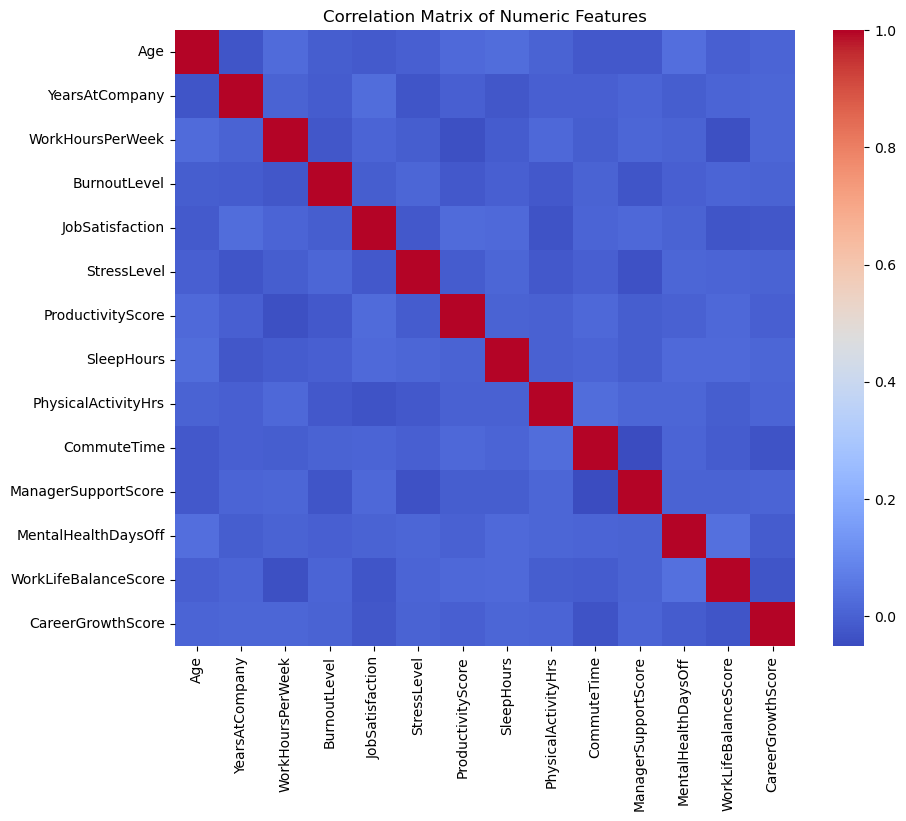

In [11]:
# Step 1: Select only numeric features
numeric_df = df[num_cols]   # numeric_cols from earlier

# Step 2: Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Step 3: Display the correlation matrix
print(corr_matrix.head())

# Step 4: Visualize it
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

### PCA Analysis

PCA was used to understand whether the dataset has strong structure and whether dimensionality reduction would improve clustering.




In [12]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA()

In [13]:
def calculate_cum_var_exp(eig_vals):
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    return cum_var_exp

In [14]:
def plot_var_exp(eig_vals):

    cum_var_exp = calculate_cum_var_exp(eig_vals)

    plt.figure(figsize=(9,7))

    component_number = [i+1 for i in range(len(cum_var_exp))]

    plt.plot(component_number, cum_var_exp, lw=7)

    plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
    plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')

    ax = plt.gca()
    ax.set_xlim([1,30])
    ax.set_ylim([-5,105])

    ax.set_ylabel('cumulative variance explained', fontsize=16)
    ax.set_xlabel('component', fontsize=16)

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(12)

    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(12)

    ax.set_title('component vs cumulative variance explained\n', fontsize=20)

    plt.show()

### Conclusion

Because PCA does not effectively reduce dimensionality here:

PCA should not be used for clustering.

K-Means should be applied directly on the full scaled + encoded feature set.

PCA can still be used only for visualization in 2D, but not as a dimensionality reduction step for modeling.

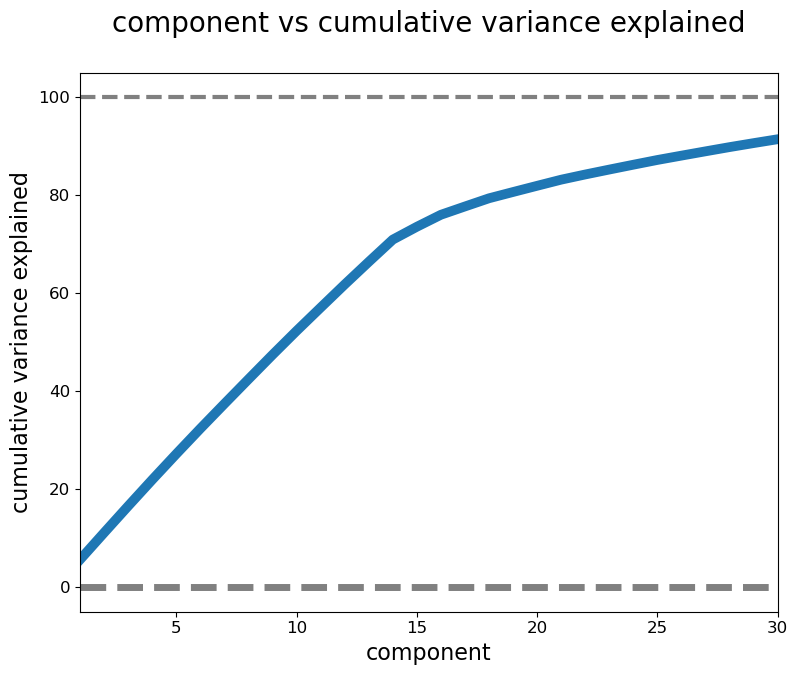

In [15]:
# Plot cumulative variance explained vs number of components with custom plot_var_exp function
plot_var_exp(pca.explained_variance_)

### K-Means algorithm
#### Elbow Method
Elbow method to visualise which is the most optimal clusters from visualisation alone

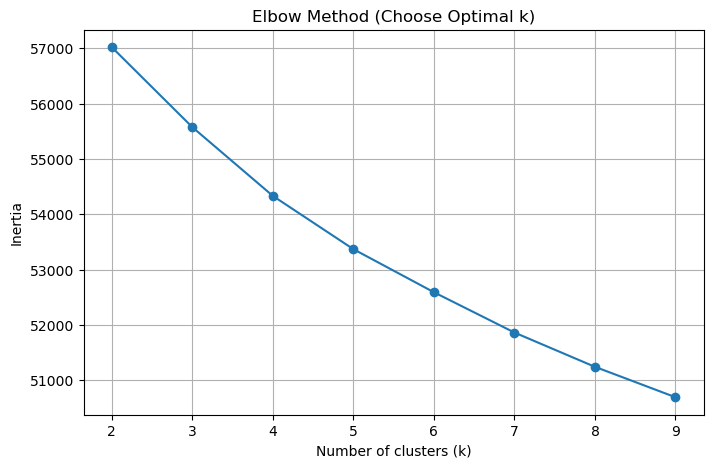

In [42]:
from sklearn.cluster import KMeans

# Elbow Method to find best number of clusters
# ----------------------------------------------------------
inertia_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia_scores.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia_scores, marker='o')
plt.title("Elbow Method (Choose Optimal k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid()
plt.show()

#### Silhouette Score
Silhouette Score is like a scientific measurement telling you which k is mathematically best.

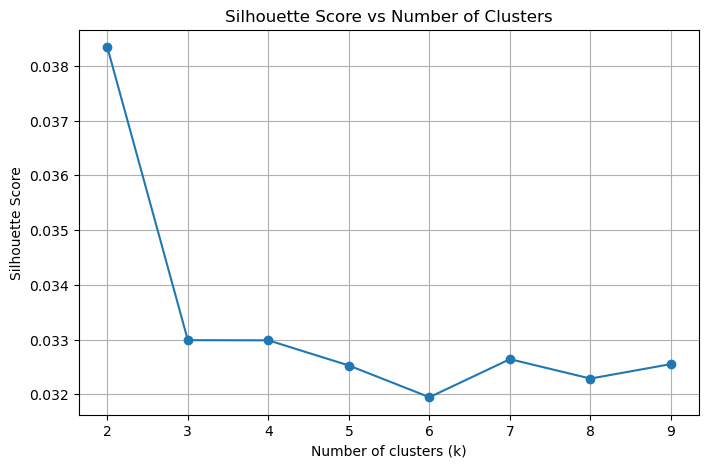

Silhouette Score results:
Cluster 2: 0.0383
Cluster 3: 0.0330
Cluster 4: 0.0330
Cluster 5: 0.0325
Cluster 6: 0.0319
Cluster 7: 0.0326
Cluster 8: 0.0323
Cluster 9: 0.0326

Best number of clusters based on silhouette score: 2(0.0383)


In [43]:
# 6. Silhouette Score for additional validation
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

print("Silhouette Score results:")
for k, eachScore in enumerate(silhouette_scores):
     print(f"Cluster {k+2}: {eachScore:.4f}")

best_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"\nBest number of clusters based on silhouette score: {best_k}({max(silhouette_scores):.4f})")

In [46]:
# 8. Final K-Means using optimal k
# ----------------------------------------------------------
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels = kmeans.fit_predict(X)

df["Cluster"] = final_labels

# ----------------------------------------------------------
# 9. View cluster sizes + numeric profiles
# ----------------------------------------------------------
print("\nCluster Counts:")
print(df["Cluster"].value_counts())

print("\nCluster Profile (Numerical Features):")
print(df.groupby("Cluster")[num_cols].mean())


Cluster Counts:
Cluster
0    1550
1    1450
Name: count, dtype: int64

Cluster Profile (Numerical Features):
               Age  YearsAtCompany  WorkHoursPerWeek  BurnoutLevel  \
Cluster                                                              
0        41.250323       10.023226         44.127742      5.702645   
1        40.330345       10.180690         44.906207      5.302283   

         JobSatisfaction  StressLevel  ProductivityScore  SleepHours  \
Cluster                                                                
0               5.215961     5.928084           5.554206    6.615613   
1               5.674317     5.074152           5.482524    6.457103   

         PhysicalActivityHrs  CommuteTime  ManagerSupportScore  \
Cluster                                                          
0                   4.900129    62.559355             3.328935   
1                   5.169655    55.664828             7.701910   

         MentalHealthDaysOff  WorkLifeBalanceScore  Car

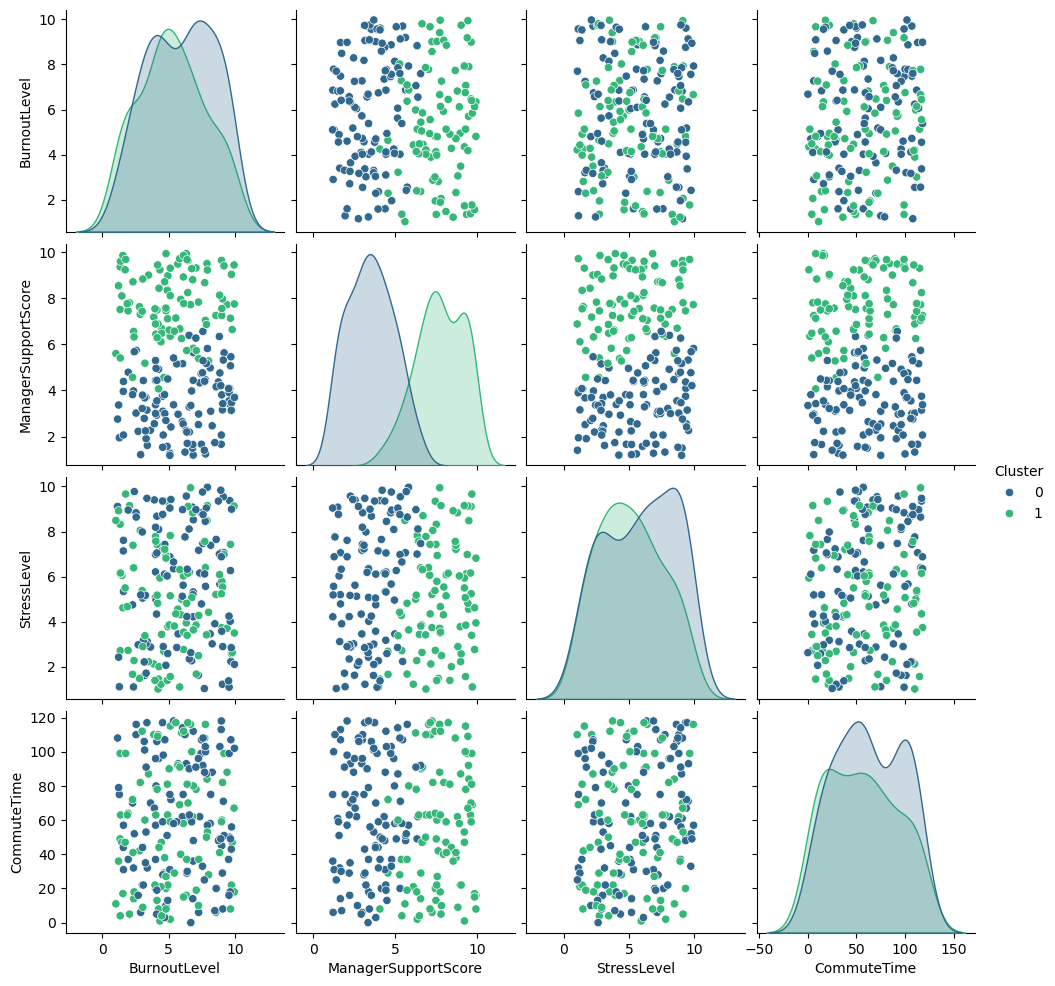

In [49]:
import seaborn as sns

# Sample only 200 points for readability
sample = df.sample(200, random_state=42)

sns.pairplot(
    sample,
    vars=["BurnoutLevel", "ManagerSupportScore", "StressLevel", "CommuteTime"],
    hue="Cluster",
    palette="viridis"
)
plt.show()


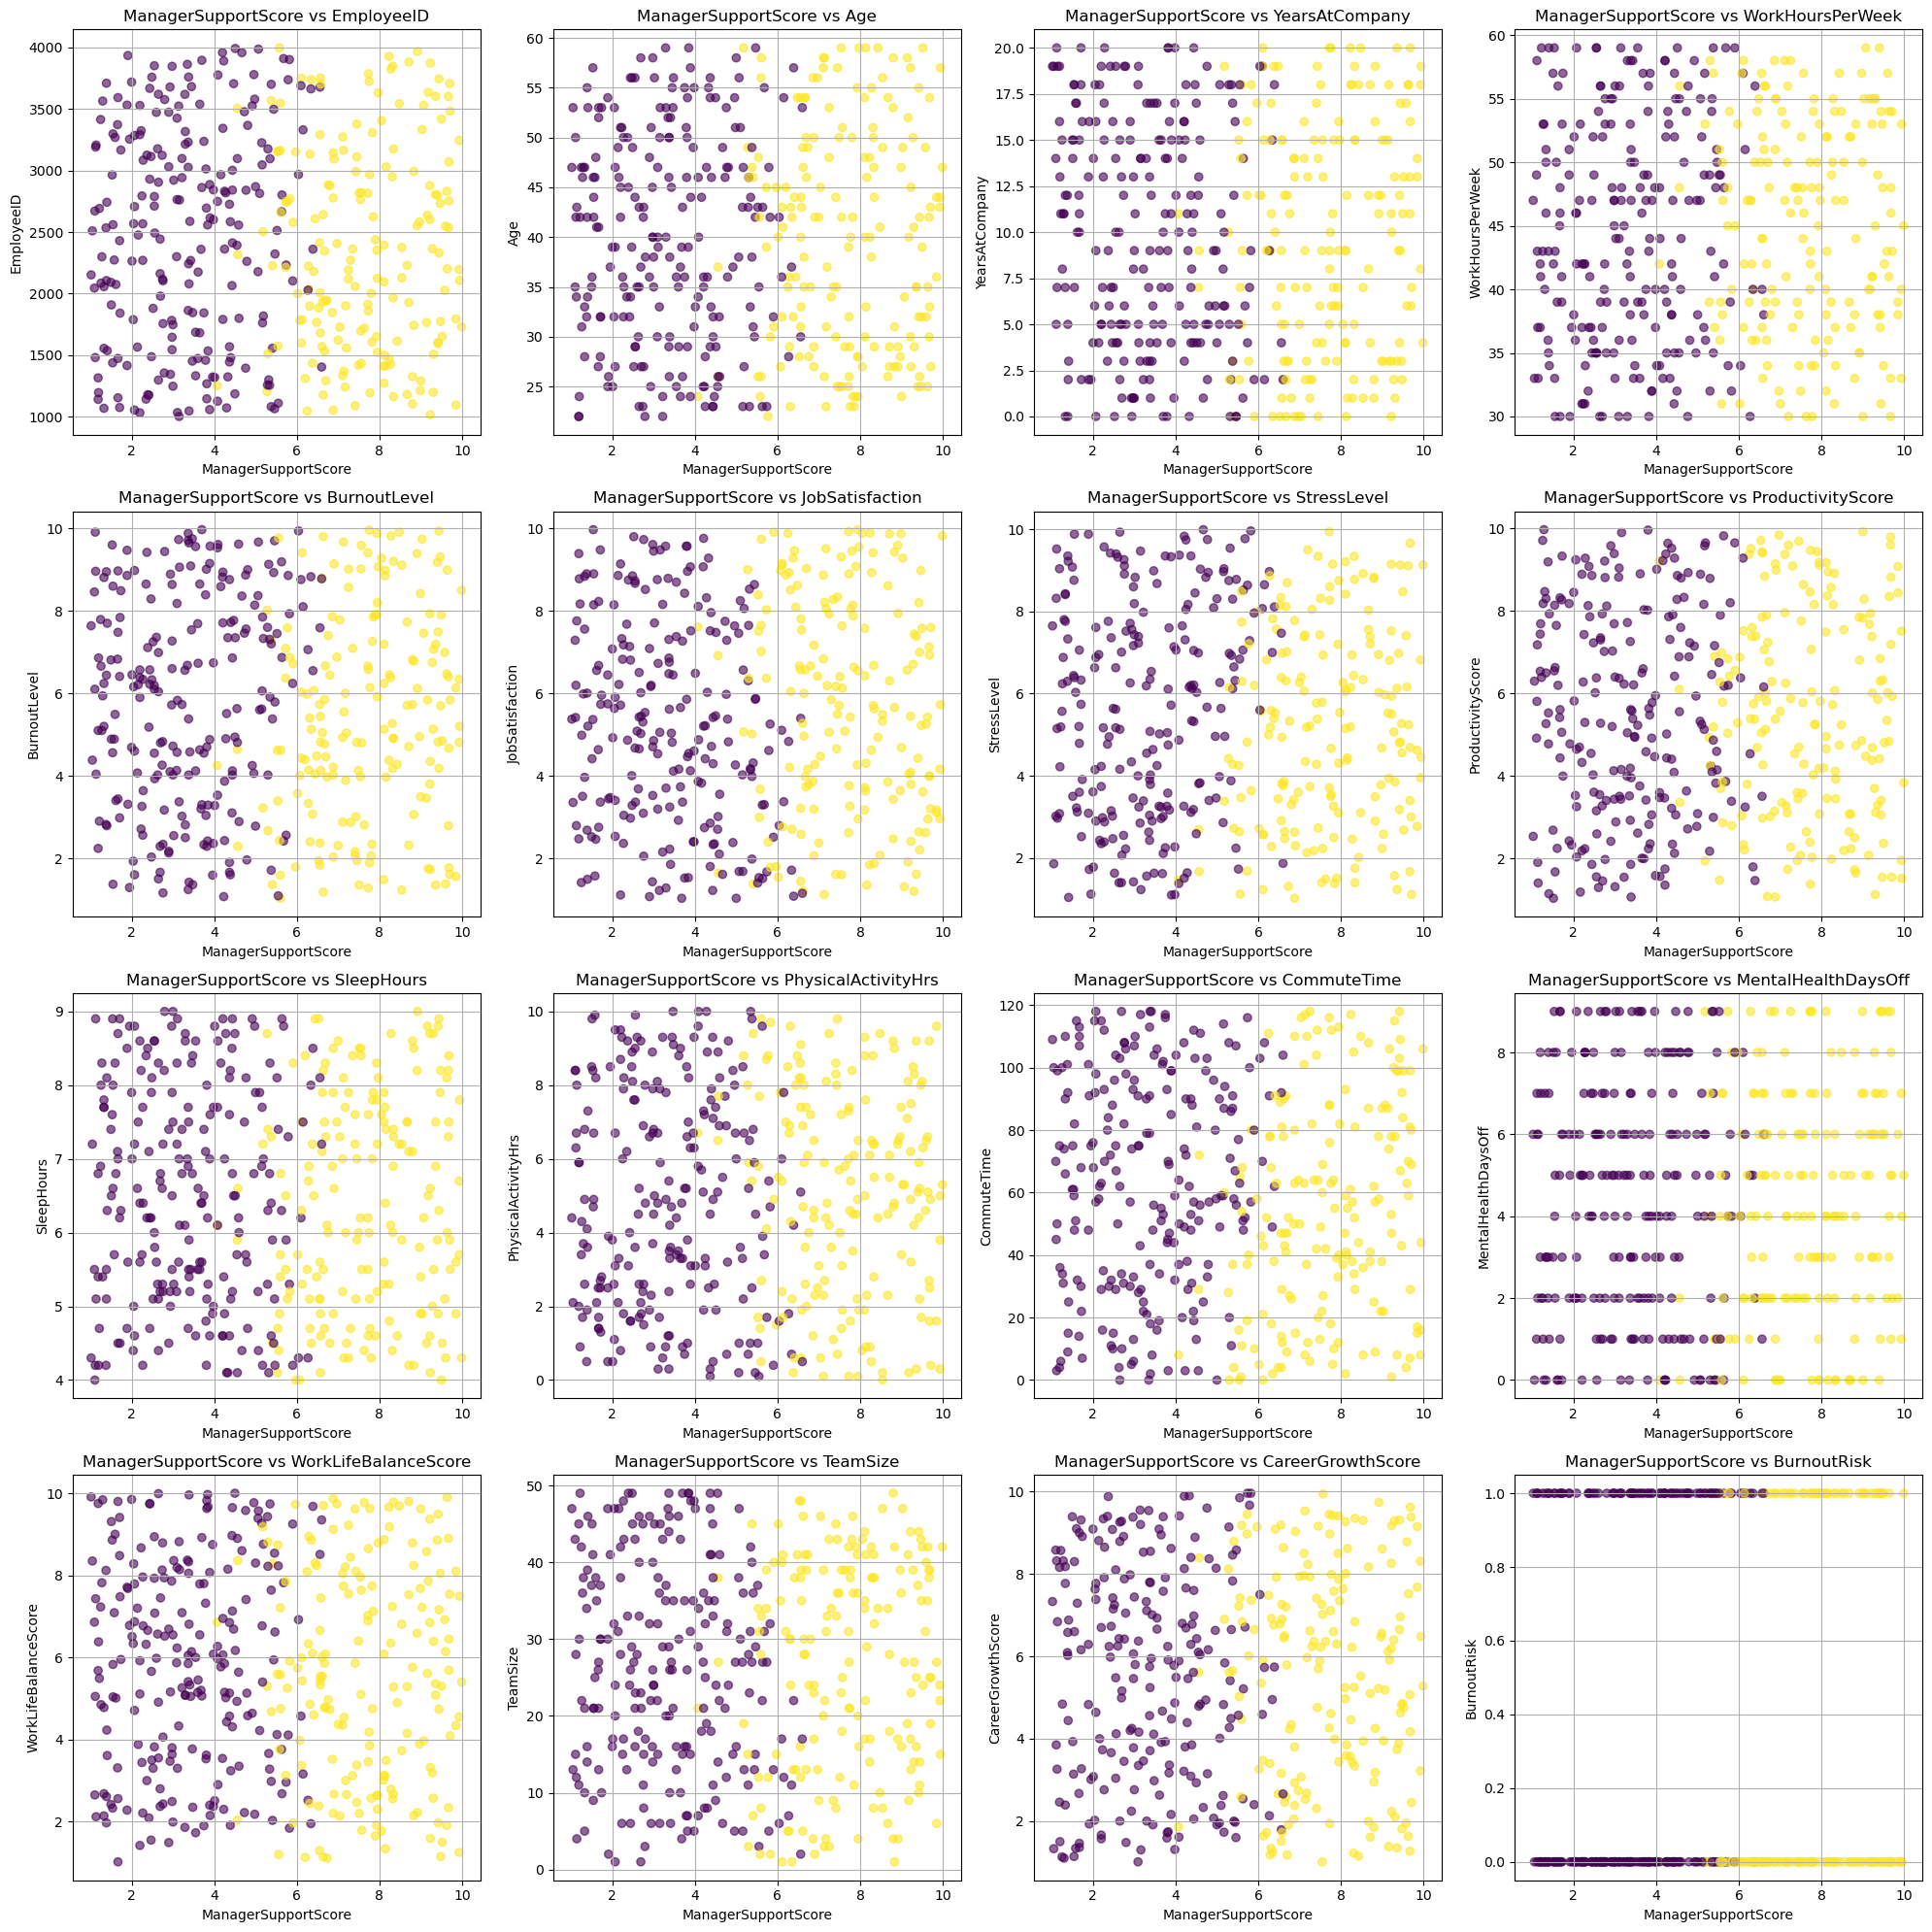

In [57]:
import matplotlib.pyplot as plt
import math

# Take a sample
sample = df.sample(400, random_state=42)

# Numeric columns except ManagerSupportScore
numeric_cols = sample.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols.remove("ManagerSupportScore")

# Grid settings
plots_per_row = 4
num_plots = len(numeric_cols)
num_rows = math.ceil(num_plots / plots_per_row)

plt.figure(figsize=(20, 5 * num_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, plots_per_row, i + 1)
    plt.scatter(
        sample["ManagerSupportScore"],
        sample[col],
        c=sample["Cluster"],
        cmap="viridis",
        alpha=0.6
    )
    plt.title(f"ManagerSupportScore vs {col}")
    plt.xlabel("ManagerSupportScore")
    plt.ylabel(col)
    plt.grid(True)

plt.tight_layout()
plt.show()


C:\Users\Aaron\AppData\Local\Temp\ipykernel_12056\3558373031.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette="viridis")


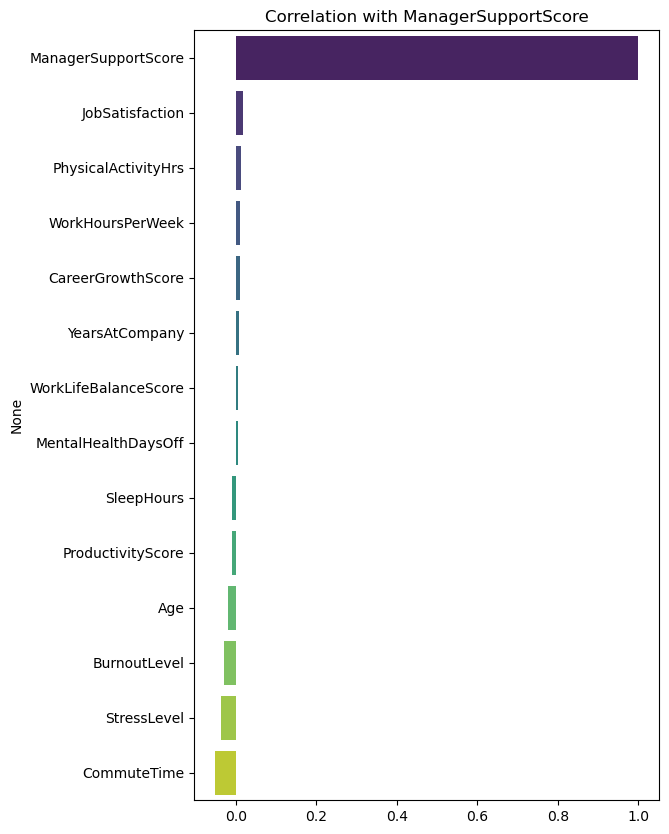

Correlation with ManagerSupportScore (Highest → Lowest):

ManagerSupportScore       : 1.0000
JobSatisfaction           : 0.0176
PhysicalActivityHrs       : 0.0129
WorkHoursPerWeek          : 0.0109
CareerGrowthScore         : 0.0095
YearsAtCompany            : 0.0073
WorkLifeBalanceScore      : 0.0060
MentalHealthDaysOff       : 0.0045
SleepHours                : -0.0092
ProductivityScore         : -0.0093
Age                       : -0.0197
BurnoutLevel              : -0.0286
StressLevel               : -0.0378
CommuteTime               : -0.0512


In [59]:
corr = df[num_cols].corr()["ManagerSupportScore"].sort_values(ascending=False)

plt.figure(figsize=(6,10))
sns.barplot(x=corr.values, y=corr.index, palette="viridis")
plt.title("Correlation with ManagerSupportScore")
plt.show()


print("Correlation with ManagerSupportScore (Highest → Lowest):\n")
for feature, value in corr.items():
    print(f"{feature:25s} : {value:.4f}")


## 3.2 NLP and Unsupervised Clustering Analysis

In [9]:
file_name = "data/mental_health_15_descriptions.csv"
df_15_descriptions = pd.read_csv(file_name)  # your dataset
texts = df_15_descriptions["SurveyDescription"].astype(str).tolist()

In [10]:
# Print test from a list
print("Row 1:")
texts[0]

Row 1:


'As a 10-year veteran in the Customer Support role, I feel overwhelmed by the excessive demands and stress (2.61) that has pushed my burnout level to 4.26, affecting my overall wellbeing. Despite having access to therapy, I often find it challenging to maintain a healthy work-life balance, especially with a 60-minute commute and only 7.3 hours of sleep daily. My ManagerSupportScore of 2.93 and SalaryRange of 40K-60K fail to offset the dissatisfaction I feel in my job, further impacting my wellbeing and causing mental health days off.'

#### TF-IDF Training

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=3000,
    stop_words='english',
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(texts)
print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (120, 3000)


### SBERT Training

In [12]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

X_sbert = model.encode(texts, show_progress_bar=True)
print("SBERT shape:", X_sbert.shape)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

SBERT shape: (120, 384)


In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_best_k(X, k_min=2, k_max=12):
    sse = []
    silhouette_scores = []
    K_range = range(k_min, k_max + 1)

    print("Running K-Means for different K values...\n")
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)

        # Sum of squared errors (elbow)
        sse.append(kmeans.inertia_)

        # Silhouette score
        sil = silhouette_score(X, labels)
        silhouette_scores.append(sil)

        print(f"K={k}: SSE={kmeans.inertia_:.2f}, Silhouette={sil:.4f}")
    
    # --- Plot Elbow ---
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(K_range, sse, marker='o')
    plt.title("Elbow Method (SSE)")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("SSE / Inertia")

    # --- Plot Silhouette ---
    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, marker='o', color='orange')
    plt.title("Silhouette Scores")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")

    plt.tight_layout()
    plt.show()

    # --- Auto-select best K ---
    best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"\n🔥 Best K (highest silhouette score): {best_k}\n")

    # Re-run KMeans for the best K
    best_kmeans = KMeans(n_clusters=best_k, random_state=42)
    best_labels = best_kmeans.fit_predict(X)

    return best_k, best_kmeans, best_labels


Running K-Means for different K values...



c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

K=2: SSE=33.66, Silhouette=0.0461
K=3: SSE=32.63, Silhouette=0.0442
K=4: SSE=30.92, Silhouette=0.0548
K=5: SSE=29.83, Silhouette=0.0556
K=6: SSE=29.28, Silhouette=0.0470
K=7: SSE=28.56, Silhouette=0.0530
K=8: SSE=28.09, Silhouette=0.0407


c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

K=9: SSE=27.26, Silhouette=0.0400
K=10: SSE=26.76, Silhouette=0.0379
K=11: SSE=26.42, Silhouette=0.0337
K=12: SSE=26.06, Silhouette=0.0294


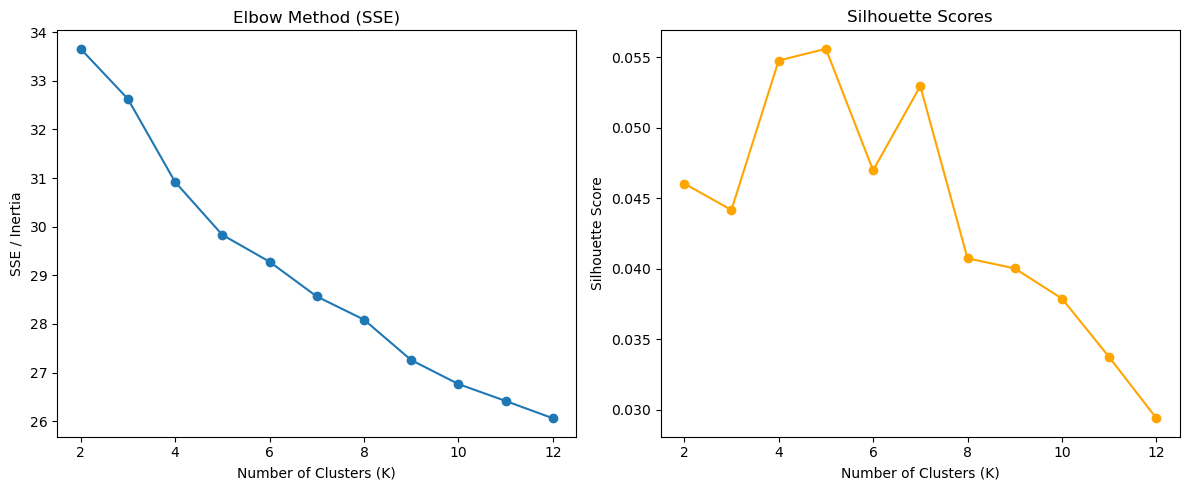


🔥 Best K (highest silhouette score): 5



c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [14]:
best_k, best_model, labels = find_best_k(X_sbert, k_min=2, k_max=12)


In [15]:
from sklearn.cluster import KMeans
k = best_k
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_sbert)

df_15_descriptions["cluster"] = clusters

c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_sbert)


In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_pca)


In [18]:
import numpy as np

def top_keywords(cluster_id, tfidf_matrix, tfidf_model, clusters, top_n=10):
    idx = np.where(clusters == cluster_id)[0]
    sub = tfidf_matrix[idx].mean(axis=0)
    scores = sub.A1
    top_idx = scores.argsort()[::-1][:top_n]
    return [tfidf_model.get_feature_names_out()[i] for i in top_idx]

for c in range(k):
    print(f"\nCluster {c} Keywords:")
    print(top_keywords(c, X_tfidf, tfidf, clusters))



Cluster 0 Keywords:
['work', 'hr', 'hr specialist', 'specialist', 'hours', 'high', 'time', 'physical', 'stress', 'levels']

Cluster 1 Keywords:
['manager', 'marketing manager', 'marketing', 'work', 'support', 'mental', 'health', 'wellbeing', 'mental health', 'stress']

Cluster 2 Keywords:
['scientist', 'data scientist', 'data', 'work', 'career growth', 'growth', 'career', 'feel', 'physical', 'hours']

Cluster 3 Keywords:
['brazil', 'brazil feel', 'work', 'mental', 'health', 'hours', 'job', 'mental health', 'support', 'long']

Cluster 4 Keywords:
['work', 'hours', 'mental health', 'health', 'mental', 'support', 'burnout', 'wellbeing', 'job', 'life']


In [19]:
for c in range(k):
    print(f"\n=== Cluster {c} Examples ===")
    sample = df_15_descriptions[df_15_descriptions.cluster == c]["SurveyDescription"].head(3)
    for s in sample:
        print("-", s)


=== Cluster 0 Examples ===
- Working in a Customer Support role while having an unbalanced work-life situation affects my overall wellbeing. The high stress levels and long commute time take a toll on my mental and physical health. A hybrid remote work setup with high job satisfaction and a relatively good work-life balance score is overshadowed by the significant burnout and lack of mental health support.
- As an HR Specialist in Germany, I'm struggling to maintain a decent work-life balance with my demanding job that requires me to be present in the office for 37 hours a week, coupled with a 43-minute daily commute. Despite having excellent manager support and access to mental health resources, my high stress levels and lack of career growth opportunities are starting to take a toll on my overall wellbeing. I'm constantly exhausted, averaging only 4.1 hours of sleep per night, and my physical activities are limited due to my busy schedule.
- As an HR Specialist, I often find myself 

### Classify those clusters list results into cluster names

In [20]:
cluster_names = {
    0: "High Workload & Physical Stress",
    1: "Manager Support & Wellbeing",
    2: "Career Growth & Role Development",
    3: "Brazil Team – Mental Health Concerns",
    4: "Burnout & Work–Life Balance"
}

In [21]:
df_15_descriptions["ClusterName"] = df_15_descriptions["cluster"].map(cluster_names)

### Showcase the clusters visualisation into a scatterplot

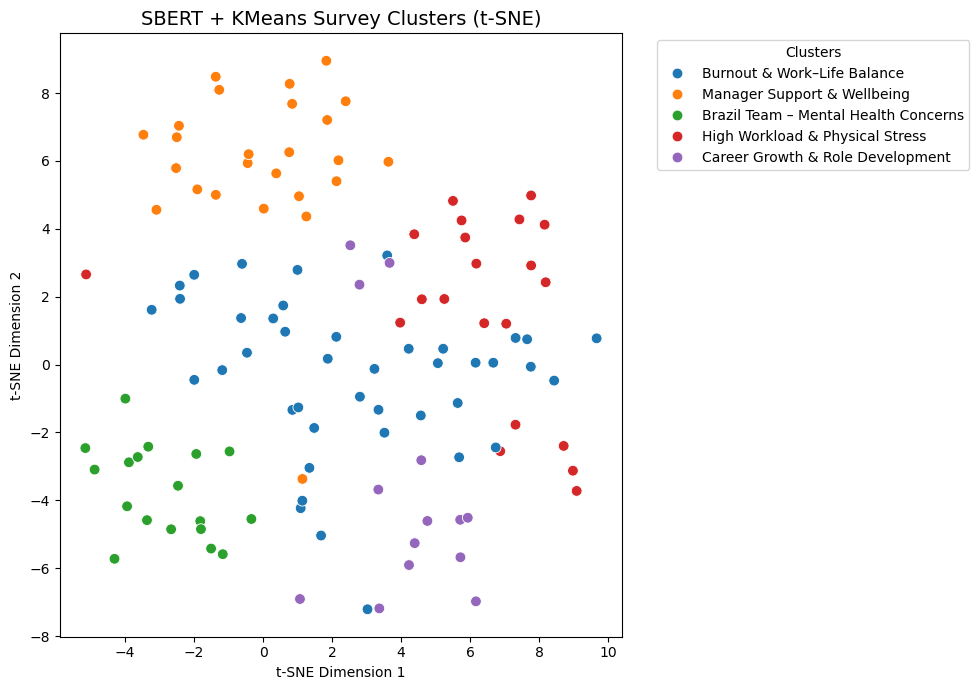

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=df_15_descriptions["ClusterName"],
    palette="tab10",
    s=60
)

plt.title("SBERT + KMeans Survey Clusters (t-SNE)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


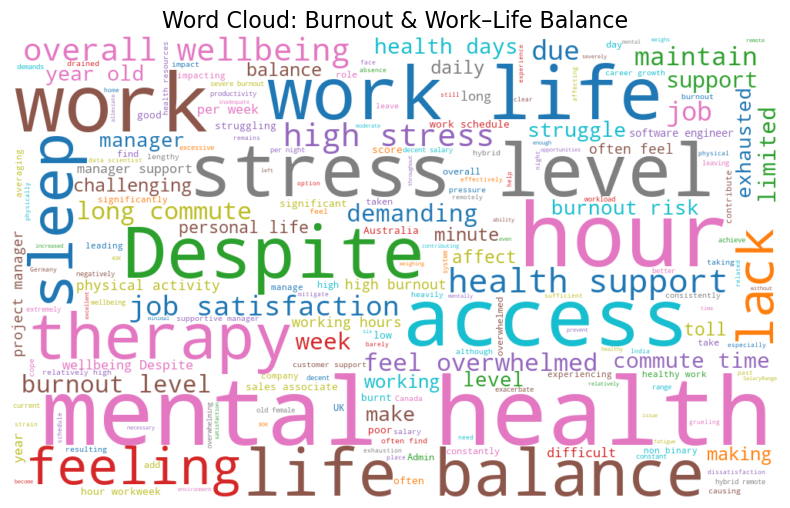

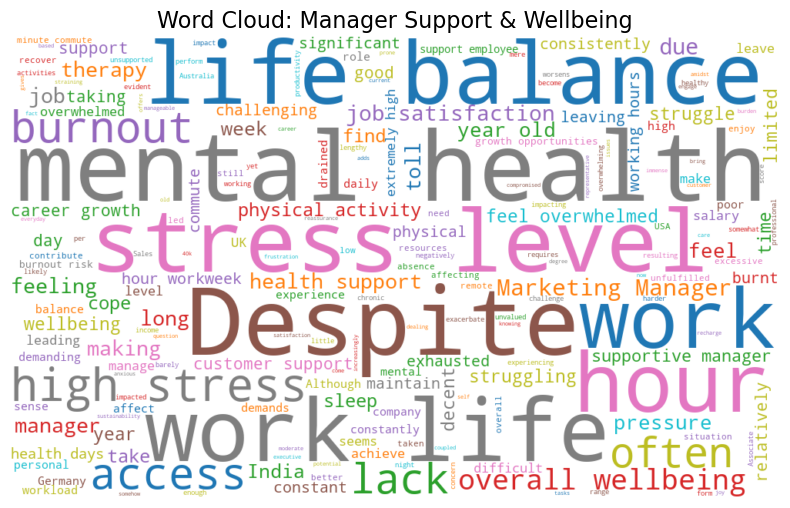

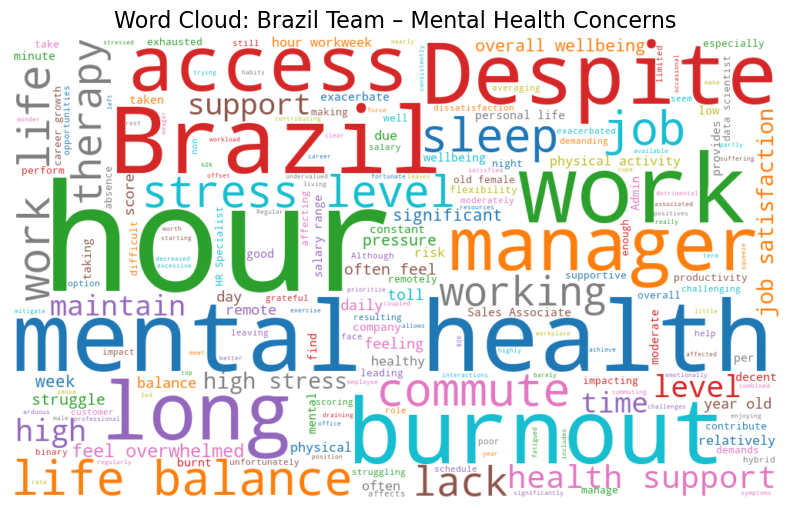

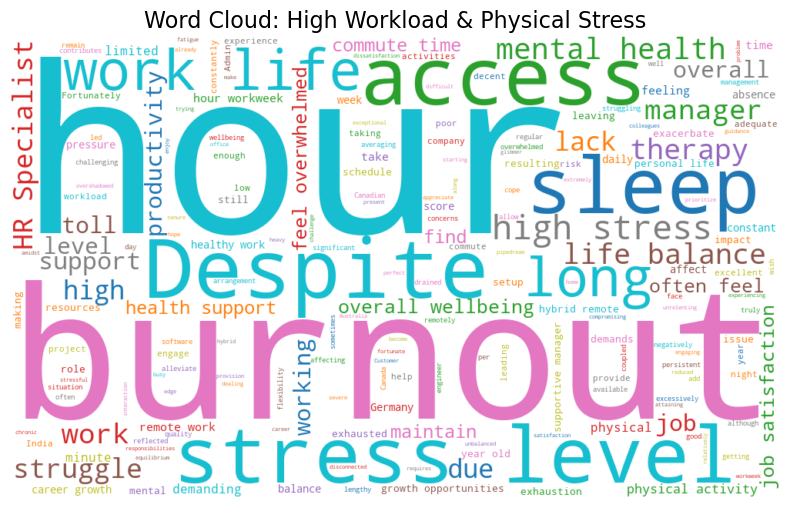

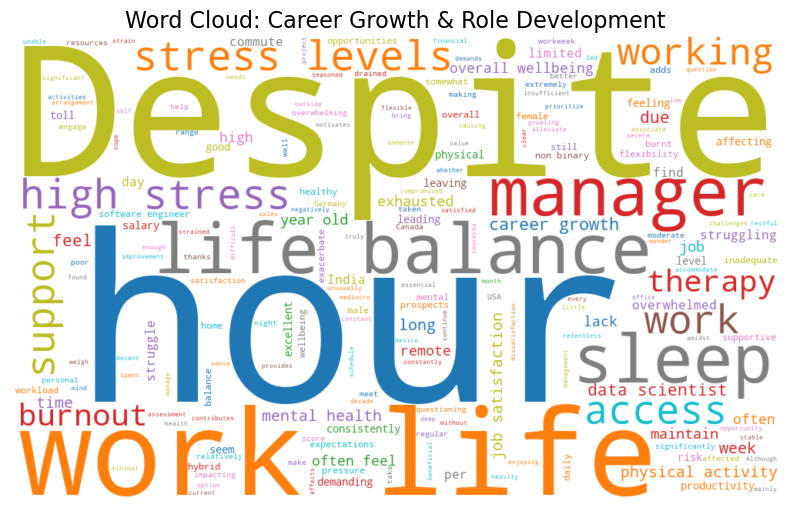

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ensure the column exists:
# df_15_descriptions["ClusterName"] already assigned from before

unique_clusters = df_15_descriptions["ClusterName"].unique()

for cluster in unique_clusters:
    # Combine all text data in this cluster into one long string
    text = " ".join(
        df_15_descriptions[df_15_descriptions["ClusterName"] == cluster]["SurveyDescription"].astype(str)
    )
    
    # Generate the word cloud
    wc = WordCloud(
        width=1000,
        height=600,
        background_color="white",
        colormap="tab10"
    ).generate(text)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud: {cluster}", fontsize=16)
    plt.show()



Processing Cluster: Burnout & Work–Life Balance


C:\Users\Aaron\AppData\Local\Temp\ipykernel_24712\3414557477.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_, y=words_, palette="tab10")


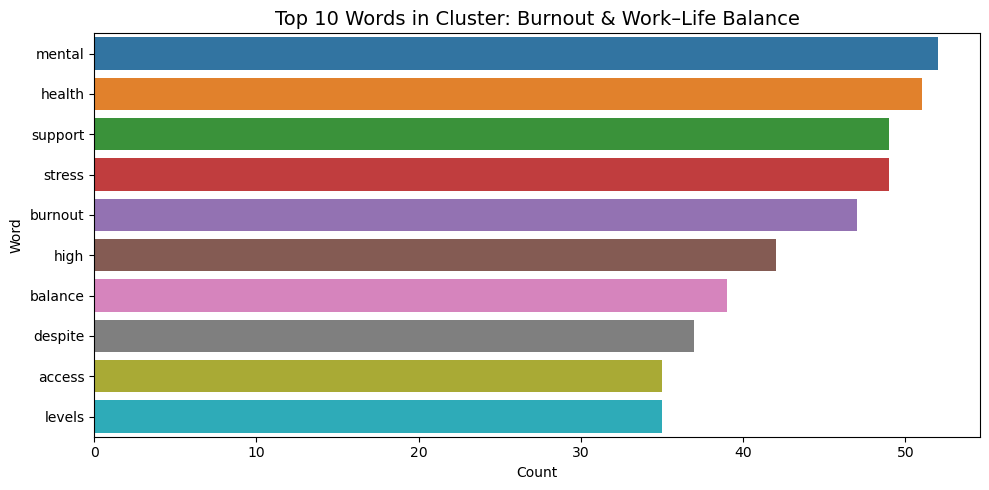

Top 10 Words for Burnout & Work–Life Balance:
mental: 52
health: 51
support: 49
stress: 49
burnout: 47
high: 42
balance: 39
despite: 37
access: 35
levels: 35

Processing Cluster: Manager Support & Wellbeing


C:\Users\Aaron\AppData\Local\Temp\ipykernel_24712\3414557477.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_, y=words_, palette="tab10")


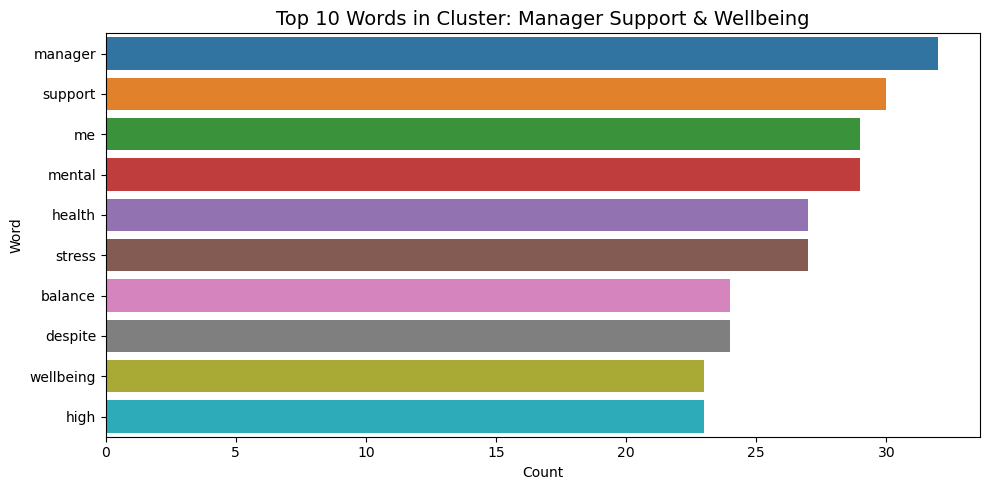

Top 10 Words for Manager Support & Wellbeing:
manager: 32
support: 30
me: 29
mental: 29
health: 27
stress: 27
balance: 24
despite: 24
wellbeing: 23
high: 23

Processing Cluster: Brazil Team – Mental Health Concerns


C:\Users\Aaron\AppData\Local\Temp\ipykernel_24712\3414557477.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_, y=words_, palette="tab10")


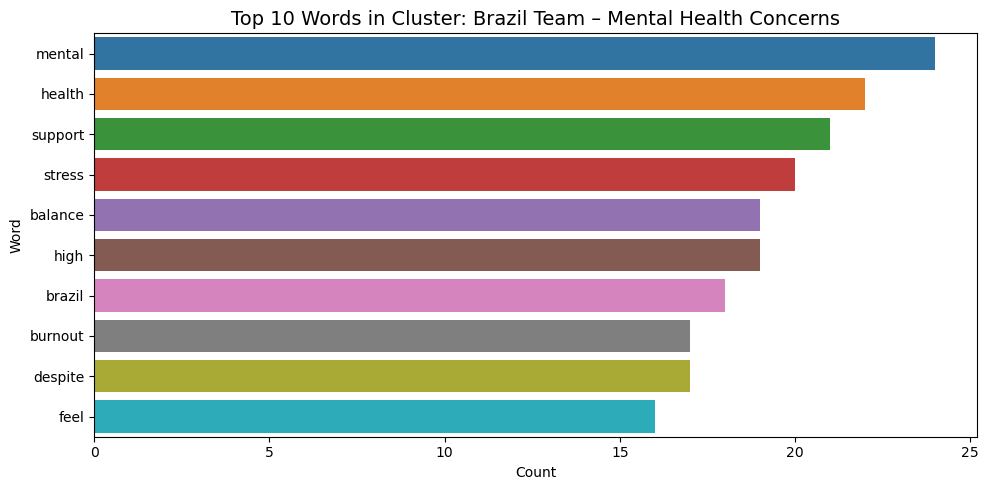

Top 10 Words for Brazil Team – Mental Health Concerns:
mental: 24
health: 22
support: 21
stress: 20
balance: 19
high: 19
brazil: 18
burnout: 17
despite: 17
feel: 16

Processing Cluster: High Workload & Physical Stress


C:\Users\Aaron\AppData\Local\Temp\ipykernel_24712\3414557477.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_, y=words_, palette="tab10")


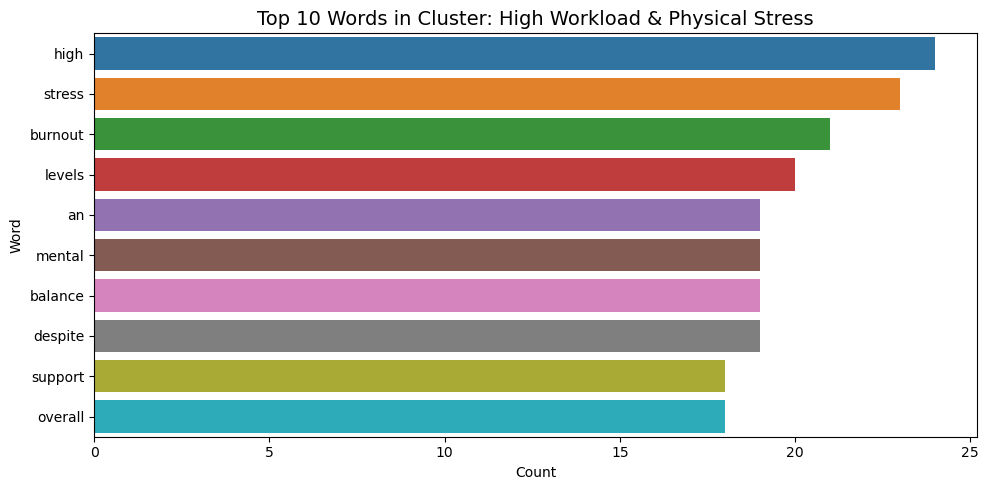

Top 10 Words for High Workload & Physical Stress:
high: 24
stress: 23
burnout: 21
levels: 20
an: 19
mental: 19
balance: 19
despite: 19
support: 18
overall: 18

Processing Cluster: Career Growth & Role Development


C:\Users\Aaron\AppData\Local\Temp\ipykernel_24712\3414557477.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_, y=words_, palette="tab10")


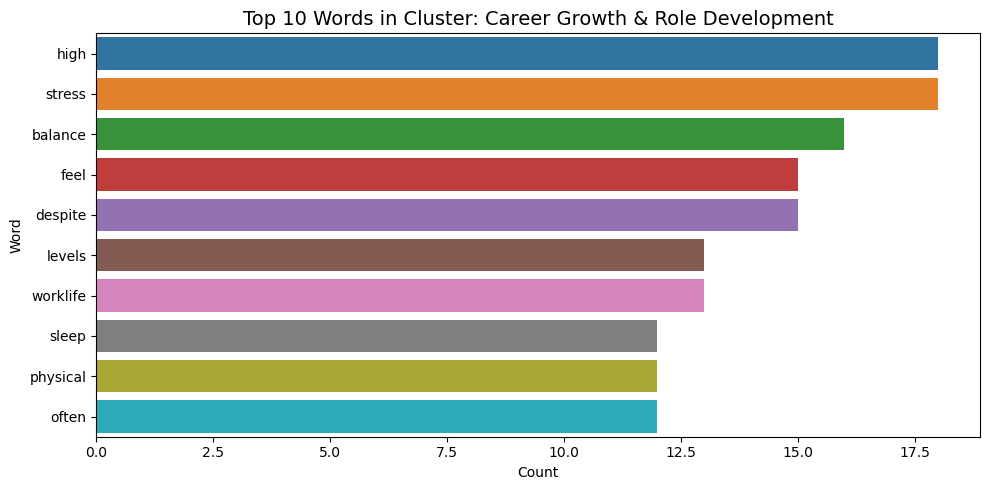

Top 10 Words for Career Growth & Role Development:
high: 18
stress: 18
balance: 16
feel: 15
despite: 15
levels: 13
worklife: 13
sleep: 12
physical: 12
often: 12


In [24]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

def clean_text(text):
    # Basic cleaning: lowercase, remove punctuation/numbers
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

unique_clusters = df_15_descriptions["ClusterName"].unique()

for cluster in unique_clusters:
    print(f"\nProcessing Cluster: {cluster}")

    # Get all text for this cluster
    texts = df_15_descriptions[df_15_descriptions["ClusterName"] == cluster]["SurveyDescription"].astype(str)

    # Clean & combine
    combined_text = " ".join(clean_text(t) for t in texts)

    # Count words
    words = combined_text.split()
    counter = Counter(words)

    # Top 10 words (excluding extremely common words)
    stopwords = set([
        "the","and","to","a","of","in","is","for","on","with",
        "it","that","this","was","are","as","be","i","my","at",
        "work","hours","job"  # keep or remove depending on your needs
    ])
    filtered = {w: c for w, c in counter.items() if w not in stopwords}

    top10 = Counter(filtered).most_common(10)

    # Data for bar chart
    words_ = [w for w, _ in top10]
    counts_ = [c for _, c in top10]

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts_, y=words_, palette="tab10")
    plt.title(f"Top 10 Words in Cluster: {cluster}", fontsize=14)
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

    # Print numeric values
    print(f"Top 10 Words for {cluster}:")
    for w, c in top10:
        print(f"{w}: {c}")


#### Conclusion: 5 Clusters

In [ ]:
# Count how many rows per cluster
cluster_counts = df_15_descriptions["ClusterName"].value_counts().reset_index()

cluster_counts.columns = ["ClusterName", "Count"]

# Calculate percentages
cluster_counts["Percentage"] = (cluster_counts["Count"] / len(df_15_descriptions) * 100).round(2)

cluster_counts

ClusterName  Count  Percentage
0           Burnout & Work–Life Balance     42       35.00
1           Manager Support & Wellbeing     25       20.83
2       High Workload & Physical Stress     21       17.50
3  Brazil Team – Mental Health Concerns     18       15.00
4      Career Growth & Role Development     14       11.67

C:\Users\Aaron\AppData\Local\Temp\ipykernel_24712\1318790732.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


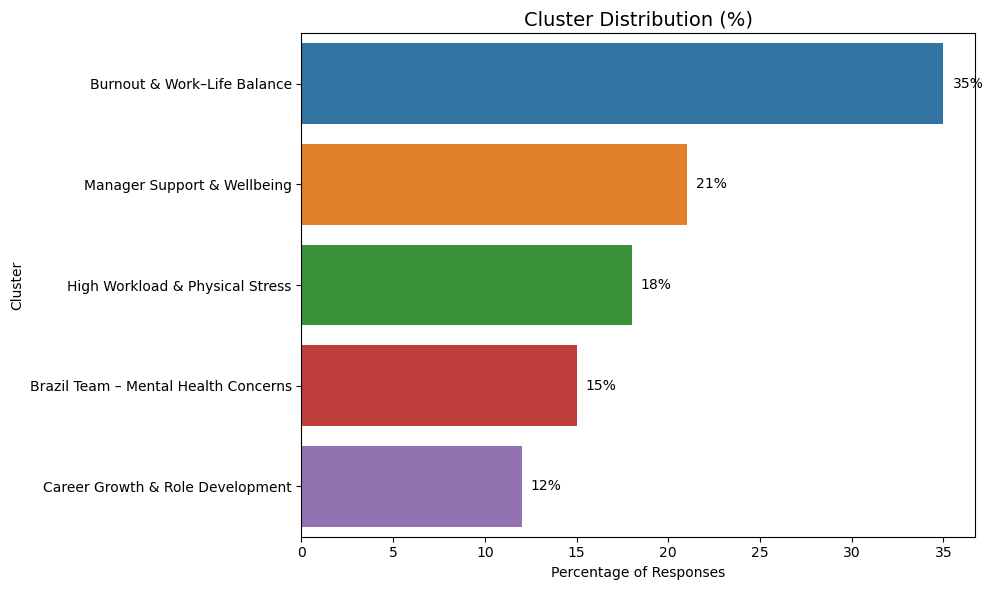

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Round the percentage column to 0 decimals
cluster_counts["Percentage0"] = cluster_counts["Percentage"].round(0).astype(int)

plt.figure(figsize=(10,6))

ax = sns.barplot(
    data=cluster_counts,
    x="Percentage0",
    y="ClusterName",
    palette="tab10"
)

# Add percentage labels (no decimals)
for i, row in cluster_counts.iterrows():
    ax.text(
        row["Percentage0"] + 0.5,     # offset right side
        i,
        f"{row['Percentage0']}%",     # integer percentage label
        va='center'
    )

plt.title("Cluster Distribution (%)", fontsize=14)
plt.xlabel("Percentage of Responses")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


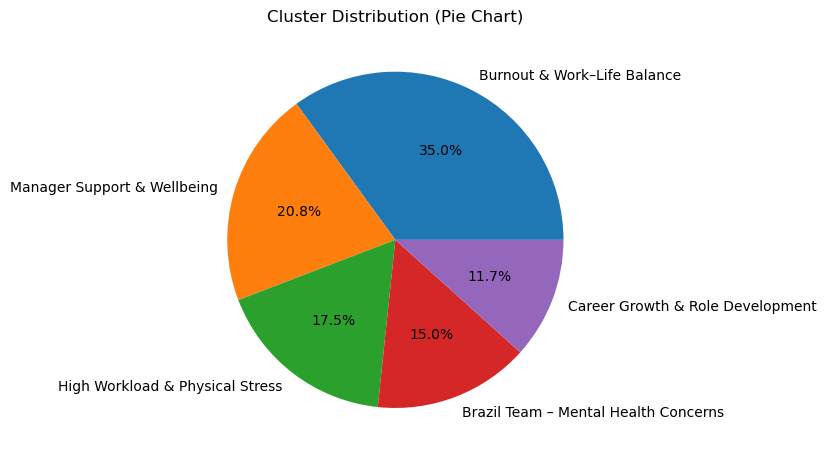

In [28]:
plt.figure(figsize=(8,8))
plt.pie(
    cluster_counts["Count"],
    labels=cluster_counts["ClusterName"],
    autopct="%1.1f%%",
    colors=sns.color_palette("tab10")
)
plt.title("Cluster Distribution (Pie Chart)")
plt.tight_layout()
plt.show()
